# LSTM Multi-Feature Stateful Stock Price Prediction with Keras 

# Overview

This is a LSTM daily stock price and trade volume forecast project using four features (AAPL and SPY's closing price and volume), 10-step inputs, and many-to-one vs. many-to-many architecture. The `stateful` is set to true to speed up the training with neighboring batch "memories" passed on. 


# Background for LSTM
The long short-term memory (LSTM) unit is an improved version of gated recurrent unit (GRU), which tries to resolve the [vanishing gradient problem](http://neuralnetworksanddeeplearning.com/chap5.html) and keep the long term "memory" activated.

See my other [project](https://github.com/ginochen/LSTM/blob/master/LSTM_min_temp.ipynb) for a picture summary on the network architecture.

# Data 
Daily data of [AAPL](https://finance.yahoo.com/quote/AAPL/history?p=AAPL) and [SPY](https://finance.yahoo.com/quote/SPY/history?p=SPY&.tsrc=fin-srch) downloaded from Yahoo Finance.

Then create batches of data with a generator:

In [40]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, ndim, skip_step=5):
        self.data = data
        self.num_steps = num_steps # forecast time steps
        self.batch_size = batch_size 
        self.ndim = ndim # number of feature dimensions
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step
    def generate(self,model,tf_session,tf_graph,model_type,stateful=False):
        if stateful==True: # reset_states (cell and hidden) to zero at the start of each epoch for stateful, i.e., don't pass last epoch states to the next epoch
            with tf_session.as_default():
                with tf_graph.as_default():
                    model.reset_states() 
        x = np.zeros((self.batch_size, self.num_steps, self.ndim))            
        if model_type is 'many_to_one': # multiple inputs to one output in the end                    
            y = np.zeros((self.batch_size, self.ndim))# make sure to set the last dim to one element, otherwise Keras won't `fit` the model!!!!!!!!!!!!!!!
        if model_type is 'many_to_many': 
            y = np.zeros((self.batch_size, self.num_steps, self.ndim))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                if model_type is 'many_to_one': # multiple inputs to one output in the end
                    x[i,:,:], y[i,:] = KerasBatchGenerator.many_to_one(self)
                if model_type is 'many_to_many': # multiple inputs to multiple outputs
                    x[i,:,:], y[i,:,:] = KerasBatchGenerator.many_to_many(self)
                self.current_idx += self.skip_step                
            yield x, y
    def many_to_many(self):
        x = self.data[self.current_idx    :self.current_idx + self.num_steps,     :] # (batchsize,nstep,ndim)
        y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1, :]
        return x,y
    def many_to_one(self):   
        x = self.data[self.current_idx    :self.current_idx + self.num_steps,    :]
        y = self.data[self.current_idx + self.num_steps + 1,:]
        return x,y

Import and create the batched data: 

In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
datapath = 'data/'
series_aapl = pd.read_csv('data/AAPL.csv')
series_spy = pd.read_csv('data/SPY.csv')
#series = pd.concat([series_aapl['Close'],series_aapl['Volume'],series_spy['Close'],series_spy['Volume']],axis=1)
series = np.stack((series_aapl['Close'].values,series_aapl['Volume'].values,series_spy['Close'].values,series_spy['Volume'].values),axis=1)
n = series.shape[0] # total time series length
nsteps = 10
batchsize = 20 # Number of samples per gradient update.
lagt=1
prediction_len = 10 # forecast lead time steps
ndim = series.shape[1] # number of features
hdim=100
nepochs=200
stateful_=True
dropoutRate=0.2
if stateful_:
    shuffle_batch=False # don't shuffle the sequence order if passing states in order between batches
prediction_len = nsteps
window_size = 1

# split data into 80% training, 10% validating,10% testing
train,valid,test = series[:round(0.8*n),:], series[round(0.8*n):round(0.9*n),:], series[round(0.9*n):,:]
print('Train data snippet: \n AAPL closing price, AAPL trading volume, SPY closing price, SPY trading volume \n',train[:5,:])
# scale the data into range of X.min = 0 to X.max = 1
scaler = MinMaxScaler(feature_range=(-1, 1))
# Transformation is given by:
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min = X_std * 1 + 0 = X_std when scaled between (0,1)
# X = X_std*(X.max - X.min) + X.min
scaler.fit(test)
xmin, xmax = scaler.data_min_, scaler.data_max_

train = scaler.fit_transform(X=train)
valid = scaler.fit_transform(X=valid)
test  = scaler.fit_transform(X=test)
x_inv = np.zeros((batchsize,prediction_len,ndim))
for i in range(batchsize):
    x_inv[i,:,:] = scaler.inverse_transform(test[i*prediction_len:(i+1)*prediction_len,:]) # x_inv is equal to test if scaler.fit is done on test
print('\nTransformed data snippet:\n', train[:5])

# create batched data (batchsize,nsteps,ndim)
train_data_generator = KerasBatchGenerator(train, nsteps, batchsize, ndim, skip_step=nsteps)
valid_data_generator = KerasBatchGenerator(valid, nsteps, batchsize, ndim, skip_step=nsteps)

#x_train,x_valid        = series[:round(0.8*n)], series[round(0.8*n):round(0.9*n)]
#y_train,y_valid,y_test = series.iloc[:,0][lagt:round(0.8*n)+lagt], series.iloc[:,0][round(0.8*n)+lagt:round(0.9*n)+lagt], series.iloc[:,0][round(0.9*n)+lagt:]
print('\n Shape of training and validation data set:\n',train.shape,valid.shape)


Train data snippet: 
 AAPL closing price, AAPL trading volume, SPY closing price, SPY trading volume 
 [[4.55171430e+01 7.04396000e+07 1.22489998e+02 1.56107100e+08]
 [4.51542850e+01 9.58860000e+07 1.21610001e+02 1.86621600e+08]
 [4.54328580e+01 9.60568000e+07 1.22099998e+02 2.21387400e+08]
 [4.52357140e+01 9.03210000e+07 1.21639999e+02 1.58017600e+08]
 [4.40042840e+01 1.98961700e+08 1.20199997e+02 2.39068800e+08]]

Transformed data snippet:
 [[-0.94916464 -0.74295077 -0.80654604 -0.64829903]
 [-0.95629058 -0.63201849 -0.8201001  -0.55875819]
 [-0.95081986 -0.6312739  -0.81255298 -0.45674247]
 [-0.95469145 -0.65627883 -0.81963806 -0.64269291]
 [-0.97887473 -0.18266526 -0.84181753 -0.4048587 ]]

 Shape of training and validation data set:
 (1612, 4) (202, 4)


# Build model 
Create the function to build the many-to-one and many-to-many RNN model:

In [92]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed,Activation
import numpy as np


def build_model(hdim, nepochs, batchsize, nsteps, ndim, stateful_, model_type, dropoutRate, datapath):
    if model_type=='many_to_one':
        return_sequences_=False
    elif model_type=='many_to_many':
        return_sequences_=True

    model = Sequential()
    model.add(LSTM(hdim, batch_input_shape=(batchsize,nsteps,ndim), return_sequences=True, stateful=stateful_)) #input_shape required only at the first layer
    # hdim/units: hidden nodes
    # batch_input_shape: (batch_size, timesteps, input_dim) # input_shape takes only (timesteps, input_dim) without batch_size
    # output: (batch_size, timesteps, units), returns 3D tensor if return_sequences=True, else, 2D tensor with shape `(batch_size, units)`
    # return_sequences=True: returns the full history of hidden state outputs at all times (i.e. the shape of output is (n_samples, n_timestamps, n_outdims)), 
    #    or the return value contains only the output at the last timestamp (i.e. the shape will be (n_samples, n_outdims)), 
    #    which is invalid as the input of the next LSTM layer. 
    #
    # lstm1, state_h, state_c = LSTM(128, return_sequences=True, return_state=True) 
    # with return_state set to true, this returns the sequential hidden states, final hidden state and final cell states. 
    model.add(Dropout(dropoutRate))
    model.add(LSTM(hdim,return_sequences=return_sequences_,stateful=stateful_)) # no need to specify input_shape anymore    
    model.add(Dropout(dropoutRate))
    print('Use n-feature for Dense layer output to ensure it can be recursively fed to the input!')
    if model_type=='many_to_one':
        model.add(Dense(ndim, activation='linear')) # essentially applies 'linear' activation, a(x)=x, which returns the Dense output directly
    elif model_type=='many_to_many':
        model.add(TimeDistributed(Dense(ndim,activation='linear'))) # y(batchsize,nsteps), e.g., timedistributed is used when an identically weighted classifier CNN is added to each LSTM cell
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # metrics: Default calculates the mean accuracy rate across all predictions for multiclass classification problems
    checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model_'+model_type+'-{epoch:02d}.hdf5', verbose=1)
    # include the epoch in its naming of the model, which is good for keeping track of things.
    model.summary() 
    # 1st LSTM layer is n_param = 4 * ((inputs*outputs + outputs) + outputs^2) = 4*((4+1)*128 + 128**2) = 68096
    # 2nd LSTM layer is n_param = 4*((128+1)*128 + 128**2) = 131584
    # dense layer output is W*x+b, where W is inputs*outputs = 128*4 and b is ouputs=4, so total of 516
    return model, checkpointer



# Train model

In [108]:
import tensorflow as tf
# In order to reset_states for stateful_=True in the generater, 
# we need to pass the tensorflow session to the generator
last_epoch = 100 # set this to 0 if model never trained
#model_m2o,checkpointer_m2o  = build_model(hdim, nepochs, batchsize, nsteps, ndim, stateful_, 'many_to_one', dropoutRate, datapath)
#tf_session = keras.backend.get_session()
#tf_graph = tf.get_default_graph()
model_m2o.fit_generator(train_data_generator.generate(model_m2o,tf_session,tf_graph,model_type='many_to_one',stateful=stateful_), len(train)//(batchsize*nsteps), epochs=last_epoch+nepochs,
                        validation_data=valid_data_generator.generate(model_m2o,tf_session,tf_graph,model_type='many_to_one',stateful=stateful_),
                        validation_steps=len(valid)//(batchsize*nsteps), callbacks=[checkpointer_m2o],shuffle=shuffle_batch,initial_epoch=last_epoch)
#model_m2m,checkpointer_m2m = build_model(hdim, nepochs, batchsize, nsteps, ndim, stateful_, 'many_to_many', dropoutRate, datapath)
#tf_session = keras.backend.get_session()
#tf_graph = tf.get_default_graph()
#model_m2m.fit_generator(train_data_generator.generate(model_m2m,tf_session,tf_graph,model_type='many_to_many',stateful=stateful_), len(train)//(batchsize*nsteps), epochs=last_epoch+nepochs,
#                        validation_data=valid_data_generator.generate(model_m2m,tf_session,tf_graph,model_type='many_to_many',stateful=stateful_),
#                        validation_steps=len(valid)//(batchsize*nsteps), callbacks=[checkpointer_m2m],shuffle=shuffle_batch,initial_epoch=last_epoch)

# validation_data: evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.


Epoch 101/300
8/8 [==============================] - 0s 46ms/step - loss: 0.0151 - acc: 0.7812 - val_loss: 0.0465 - val_acc: 0.6500

Epoch 00101: saving model to data//model_many_to_one-101.hdf5
Epoch 102/300
8/8 [==============================] - 0s 23ms/step - loss: 0.0227 - acc: 0.7875 - val_loss: 0.0461 - val_acc: 0.6500

Epoch 00102: saving model to data//model_many_to_one-102.hdf5
Epoch 103/300
8/8 [==============================] - 0s 23ms/step - loss: 0.0164 - acc: 0.8313 - val_loss: 0.0471 - val_acc: 0.6500

Epoch 00103: saving model to data//model_many_to_one-103.hdf5
Epoch 104/300
8/8 [==============================] - 0s 23ms/step - loss: 0.0144 - acc: 0.8000 - val_loss: 0.0464 - val_acc: 0.6500

Epoch 00104: saving model to data//model_many_to_one-104.hdf5
Epoch 105/300
8/8 [==============================] - 0s 26ms/step - loss: 0.0155 - acc: 0.8625 - val_loss: 0.0450 - val_acc: 0.6500

Epoch 00105: saving model to data//model_many_to_one-105.hdf5
Epoch 106/300
8/8 [======

8/8 [==============================] - 0s 31ms/step - loss: 0.1184 - acc: 0.7875 - val_loss: 0.0584 - val_acc: 0.6500

Epoch 00143: saving model to data//model_many_to_one-143.hdf5
Epoch 144/300
8/8 [==============================] - 0s 26ms/step - loss: 0.0434 - acc: 0.8000 - val_loss: 0.0575 - val_acc: 0.6500

Epoch 00144: saving model to data//model_many_to_one-144.hdf5
Epoch 145/300
8/8 [==============================] - 0s 20ms/step - loss: 0.0224 - acc: 0.8688 - val_loss: 0.0448 - val_acc: 0.6500

Epoch 00145: saving model to data//model_many_to_one-145.hdf5
Epoch 146/300
8/8 [==============================] - 0s 22ms/step - loss: 0.0159 - acc: 0.8438 - val_loss: 0.0449 - val_acc: 0.6500

Epoch 00146: saving model to data//model_many_to_one-146.hdf5
Epoch 147/300
8/8 [==============================] - 0s 24ms/step - loss: 0.0161 - acc: 0.8312 - val_loss: 0.0434 - val_acc: 0.6500

Epoch 00147: saving model to data//model_many_to_one-147.hdf5
Epoch 148/300
8/8 [====================

8/8 [==============================] - 0s 24ms/step - loss: 0.0115 - acc: 0.8750 - val_loss: 0.0462 - val_acc: 0.6500

Epoch 00185: saving model to data//model_many_to_one-185.hdf5
Epoch 186/300
8/8 [==============================] - 0s 24ms/step - loss: 0.0225 - acc: 0.8312 - val_loss: 0.0450 - val_acc: 0.6500

Epoch 00186: saving model to data//model_many_to_one-186.hdf5
Epoch 187/300
8/8 [==============================] - 0s 28ms/step - loss: 0.0129 - acc: 0.8313 - val_loss: 0.0445 - val_acc: 0.6500

Epoch 00187: saving model to data//model_many_to_one-187.hdf5
Epoch 188/300
8/8 [==============================] - 0s 29ms/step - loss: 0.0176 - acc: 0.9000 - val_loss: 0.0480 - val_acc: 0.6500

Epoch 00188: saving model to data//model_many_to_one-188.hdf5
Epoch 189/300
8/8 [==============================] - 0s 29ms/step - loss: 0.0139 - acc: 0.8437 - val_loss: 0.0479 - val_acc: 0.6500

Epoch 00189: saving model to data//model_many_to_one-189.hdf5
Epoch 190/300
8/8 [====================

8/8 [==============================] - 0s 31ms/step - loss: 0.0113 - acc: 0.8625 - val_loss: 0.0455 - val_acc: 0.6500

Epoch 00227: saving model to data//model_many_to_one-227.hdf5
Epoch 228/300
8/8 [==============================] - 0s 25ms/step - loss: 0.0154 - acc: 0.8563 - val_loss: 0.0453 - val_acc: 0.6000

Epoch 00228: saving model to data//model_many_to_one-228.hdf5
Epoch 229/300
8/8 [==============================] - 0s 22ms/step - loss: 0.0128 - acc: 0.8563 - val_loss: 0.0456 - val_acc: 0.6500

Epoch 00229: saving model to data//model_many_to_one-229.hdf5
Epoch 230/300
8/8 [==============================] - 0s 34ms/step - loss: 0.0120 - acc: 0.8500 - val_loss: 0.0462 - val_acc: 0.6500

Epoch 00230: saving model to data//model_many_to_one-230.hdf5
Epoch 231/300
8/8 [==============================] - 0s 38ms/step - loss: 0.0843 - acc: 0.7750 - val_loss: 0.0533 - val_acc: 0.6500

Epoch 00231: saving model to data//model_many_to_one-231.hdf5
Epoch 232/300
8/8 [====================

8/8 [==============================] - 0s 41ms/step - loss: 0.0404 - acc: 0.7375 - val_loss: 0.0489 - val_acc: 0.6500

Epoch 00269: saving model to data//model_many_to_one-269.hdf5
Epoch 270/300
8/8 [==============================] - 0s 29ms/step - loss: 0.0165 - acc: 0.8500 - val_loss: 0.0477 - val_acc: 0.6000

Epoch 00270: saving model to data//model_many_to_one-270.hdf5
Epoch 271/300
8/8 [==============================] - 0s 33ms/step - loss: 0.0754 - acc: 0.7875 - val_loss: 0.0475 - val_acc: 0.6500

Epoch 00271: saving model to data//model_many_to_one-271.hdf5
Epoch 272/300
8/8 [==============================] - 0s 29ms/step - loss: 0.0154 - acc: 0.8437 - val_loss: 0.0441 - val_acc: 0.6500

Epoch 00272: saving model to data//model_many_to_one-272.hdf5
Epoch 273/300
8/8 [==============================] - 0s 29ms/step - loss: 0.0197 - acc: 0.7875 - val_loss: 0.0465 - val_acc: 0.6500

Epoch 00273: saving model to data//model_many_to_one-273.hdf5
Epoch 274/300
8/8 [====================

# Rebuild model with batchsize=1 for stateful simulation
The batch size is set to one, otherwise the prediction will return error since the batches should not communicate during the forecast stage.

In [56]:
def rebuild_model(i_oldmodel, model_type, dropoutRate):
    if model_type=='many_to_one':
        return_sequences_=False
    elif model_type=='many_to_many':
        return_sequences_=True
    oldmodel = keras.models.load_model('data/model_'+model_type+'-%s.hdf5'%i_oldmodel)
    if stateful_: # rebuild the exact same model as old model, but with batchsize=1
        newmodel = Sequential()
        newmodel.add(LSTM(hdim, batch_input_shape=(1,nsteps,ndim), return_sequences=True, stateful=stateful_)) 
        newmodel.add(Dropout(dropoutRate))
        newmodel.add(LSTM(hdim,return_sequences=return_sequences_,stateful=stateful_)) 
        newmodel.add(Dropout(dropoutRate))
        newmodel.add(Dense(ndim, activation='linear')) 
        # get weights from pre-trained model
        newmodel.set_weights(oldmodel.get_weights())
        # compile
        newmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    else:
        newmodel = oldmodel # if stateful==False, just use the old model
    return newmodel

# Prediction

Create a function to predict a n-day prediction by shifting the frame 1-step forward. 
The last input in the frame is then replaced by the output.

In [90]:
def predict_sequences_multiple(model, model_type, data, window_size, prediction_len):
    #Predict sequence of prediction_len steps before shifting prediction run forward by prediction_len steps
    print('[Model] Predicting Sequences Multiple...')
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)): # loop between multiple frames
        curr_frame = data[i*prediction_len:(i+1)*prediction_len,:]
        predicted = []
        for j in range(prediction_len): # loop within a frame 
            #predicted.append(model.predict(curr_frame)) # newaxis just adds a dimension
            if model_type is 'many_to_one':
                predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0]) # newaxis just adds a 1-sample-batch dimension
            if model_type is 'many_to_many':
                predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,-1]) # forecast 10 steps each with 1-lead from curr_frame, and use the last index
            # model.predict returns a shape (1,10,1), which is essentially 10 steps forward
            curr_frame = np.insert(curr_frame[1:,:], [window_size-2], predicted[-1], axis=0) # insert predicted at the last row index 
            prediction_seqs.append(predicted[-1])
    return prediction_seqs

Use the created function to predict a 10-day frame predictions and transform the noramlized data back to unnormalized:

In [88]:
def predict(i_oldmodel,prediction_len,model_type,dropoutRate,scaler,window_size,test_data,batchsize,ndim):
    # rebuild model
    newmodel = rebuild_model(i_oldmodel,model_type,dropoutRate)
    
    # predict 10 steps forward
    y = predict_sequences_multiple(newmodel, model_type, test, window_size, prediction_len)
    y = np.asarray(y).reshape(batchsize,nsteps,ndim)

    # un-scale the data  
      # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
      # X_scaled = X_std * (max - min) + min # max=1,min=0
    y_inv = np.zeros((batchsize,prediction_len,ndim))
    for i in range(batchsize):
        y_inv[i,:,:] = scaler.inverse_transform(y[i,:,:])
    return y_inv

# Best model/single epoch prediction skill
Evaluate the growth of RMSE with forecast lead time for one best model 

In [109]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rms_timeseries(nsteps,x,y):
    # evaluate the RMSE growth in 10 time steps leading the inputs
    rms = [0]*nsteps
    for i in range(nsteps-1):
        rms[i] = sqrt(mean_squared_error(x[1:,i,0], y[:-1,i,0])) # observation lag (last prediction lead) by one batch/10 steps
    print(rms)
    
prediction_len=10
window_size=1

# select the best model, and predict
y_inv_m2m = predict(394,prediction_len, 'many_to_many', dropoutRate, scaler, window_size, test_data=test,batchsize=batchsize,ndim=ndim)
rms_timeseries(nsteps,x_inv,y_inv_m2m)

y_inv_m2o = predict(187,prediction_len, 'many_to_one', dropoutRate, scaler, window_size, test_data=test, batchsize=batchsize, ndim=ndim)
rms_timeseries(nsteps,x_inv,y_inv_m2o)

[Model] Predicting Sequences Multiple...
[5.600971941476749, 7.052547050150455, 7.040707336163159, 7.223035358076331, 7.506872531384835, 7.442049230342176, 6.624667934595062, 5.997292483628946, 6.311984160315015, 0]
[Model] Predicting Sequences Multiple...
[6.044782251897478, 6.899689018468396, 6.653198072248837, 7.71106671681817, 7.86809051807377, 7.722551326613308, 7.6360849540558675, 7.533582397471816, 7.485595102862026, 0]


seems like the result show RMSE saturated at early steps.

# Best model plot

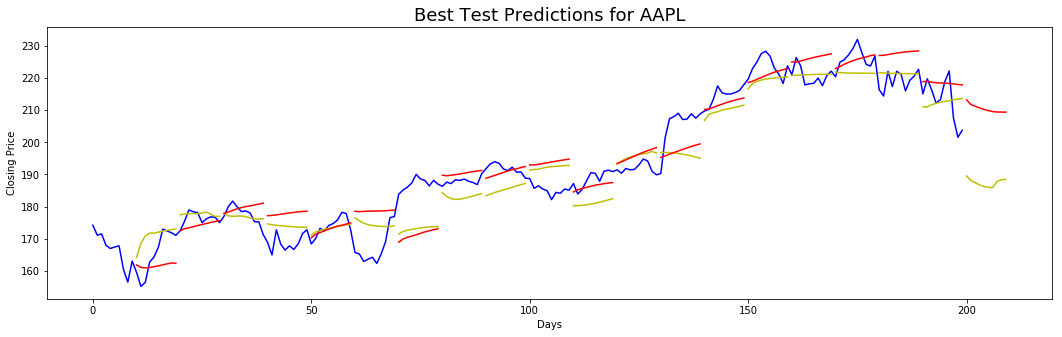

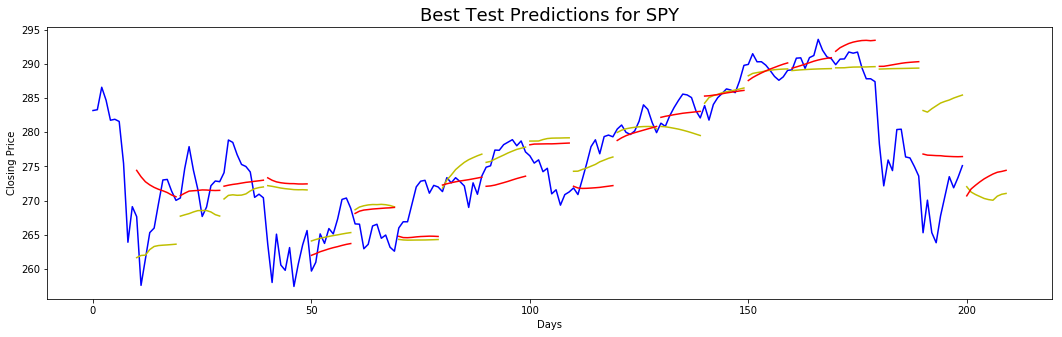

In [110]:
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import time
plt.figure(figsize = (18,5))
plt.title('Best Test Predictions for AAPL',fontsize=18)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.plot(range(0,batchsize*prediction_len),x_inv[:,:,0].reshape(-1,1),'b')
for i in range(batchsize):
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_inv_m2m[i,:,0],'y')
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_inv_m2o[i,:,0],'r')

plt.figure(figsize = (18,5))
plt.title('Best Test Predictions for SPY',fontsize=18)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.plot(range(0,batchsize*prediction_len),x_inv[:,:,2].reshape(-1,1),'b')
for i in range(batchsize):
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_inv_m2m[i,:,2],'y')
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_inv_m2o[i,:,2],'r')    
plt.show()

Many-to-many requires much longer epochs to train for a accuracy comparable to many-to-one architecture.

Since many-to-one has high accuracy oscillating after short period of epochs, for my own curiosity, let's see if ensemble average improves the overall accuracy.

# Ensemble epochs prediction skill 
Since the forecast accuracy stays similar after short period of epochs. I think it's reasonable to take the ensemble average of the epoch results to show improvements 

In [51]:
nens = 30 # pick last 30 ensemble members/epochs 
y_ens = np.zeros((batchsize,prediction_len,ndim,nens))
for i in range(nens): # obtain the ensemble
    y_ens[:,:,:,i] = predict(200-i, prediction_len=10, 'many_to_one', dropoutRate, scaler, window_size=1,test_data=test,batchsize=batchsize,ndim=ndim)


[Model] Predicting Sequences Multiple...
... ...

In [60]:
rms_ens = [0]*nsteps
for i in range(nsteps-1):
    rms_ens[i] = sqrt(mean_squared_error(x_inv[1:,i,0], y_ens[:-1,i,0,:].mean(axis=1))) # observation lag (last prediction lead) by one batch/10 steps
print(rms_ens)    

[5.551782496504366, 6.930632450331993, 7.05843922611054, 7.9175135881329926, 8.225080051927298, 8.041643648471648, 7.614917482322134, 7.062350640507447, 6.890951430637164, 0]


seems like the ensemble is doing better than single model prediction!

Save the ensemble prediction results:

In [94]:
np.savez('data/data',y_ens=y_ens, x_inv=x_inv, y_inv=y_inv)
# load data 
# data = np.load('data/data.npz')
# y_ens = data['y_ens']
# x_inv = data['x_inv']

# Ensemble mean plot

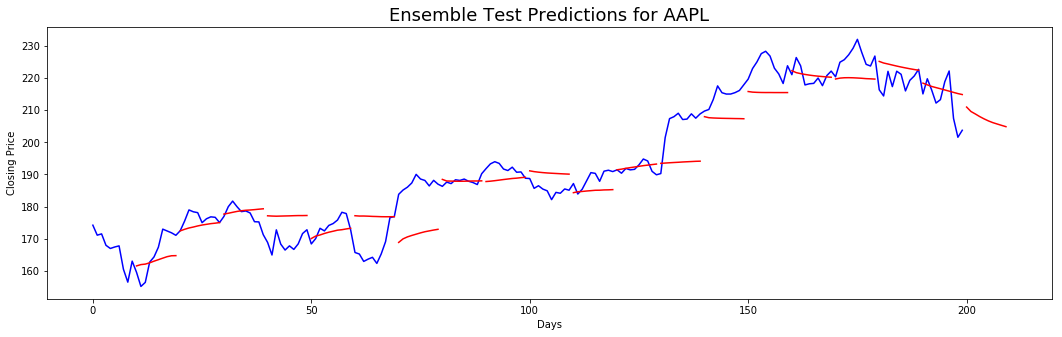

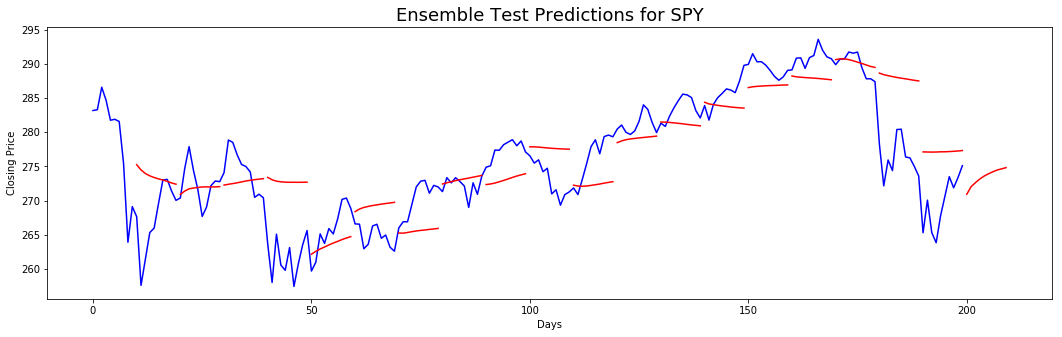

In [61]:
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import time
plt.figure(figsize = (18,5))
plt.title('Ensemble Test Predictions for AAPL',fontsize=18)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.plot(range(0,batchsize*prediction_len),x_inv[:,:,0].reshape(-1,1),'b')
for i in range(batchsize):
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_ens[i,:,0,:].mean(axis=1),'r')

plt.figure(figsize = (18,5))
plt.title('Ensemble Test Predictions for SPY',fontsize=18)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.plot(range(0,batchsize*prediction_len),x_inv[:,:,2].reshape(-1,1),'b')
for i in range(batchsize):
    plt.plot(range((i+1)*prediction_len,(i+2)*prediction_len),y_ens[i,:,2,:].mean(axis=1),'r')
plt.show()

# Summary
The purpose of this project is to show how to implement multi-feature LSTM by Keras. Apparently the stock price prediction is imperfect by using the four features and 10-lag inputs. 

Many-to-many is not a significantly better approach when compared to many-to-one by converging much slower.

Ensemble averaging the last few epochs of many-to-one results seems to reduce the RMSE, compared to the best model prediction. 

In order to use `stateful` for Keras, the following are done:
* The stateful is set to True and shuffle set to False to account for the state (cell and hidden) memory from the previous neighboring batch. 

* The states are reset (model.reset_states()) after each epoch by passing the tf_session and tf_graph into the data generator function. 

* A new model with the same architecture as the old model with batch size set to one is implemented to do the prediction. This is the 3rd solution mentioned in the [blog](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/).


The model selection in this project is done by eyeballing. Future use of [grid search](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) or [Bayesian Optimization](http://philipperemy.github.io/visualization/) should show improvements!

# Reference
* [LSTM from Keras](https://keras.io/layers/recurrent/#lstm)
* [Keras LSTM tutorial](http://adventuresinmachinelearning.com/keras-lstm-tutorial/)
* [Keras min max scaler](https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/base.py#L438)
* [Keras Stateful explained](http://philipperemy.github.io/keras-stateful-lstm/)
* [sequence prediction by "self-feeding"](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)
* [sequence prediction by "self-feeding" (source)](https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/model.py)
* [What is TimeDistributed in Keras doing?](https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras)
* [Many-to-many or Many-to-one?](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)
* [Grid search optimization using sklearn](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)
* [Bayesian Optimization explained](http://philipperemy.github.io/visualization/)
* [Stateful: How to vary batch size during training and prediction](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)